In [2]:
import tensorflow as tf
import numpy as np
import glob
import pandas as pd
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import ZeroPadding2D
from datetime import datetime

In [3]:
path = "../../../../../../../Volumes/T7 Shield/exp_1_numpy"

# Get sorted file lists
feature_files = sorted(glob.glob(f"{path}/*_features.npy"))
target_files = sorted(glob.glob(f"{path}/*_targets.npy"))

# Generate indices and shuffle
indices = np.arange(len(feature_files))
np.random.shuffle(indices)

test_idx = indices[0]
remaining_idx = indices[1:]
train_split = int(0.95 * len(remaining_idx))
train_idx = remaining_idx[:train_split]
val_idx = remaining_idx[train_split:]


# Create datasets
train_features = [feature_files[i] for i in train_idx]
train_targets = [target_files[i] for i in train_idx]

val_features = [feature_files[i] for i in val_idx]
val_targets = [target_files[i] for i in val_idx]

test_features = [feature_files[test_idx]]
test_targets = [target_files[test_idx]]

In [4]:
class LazyLoadDataset(tf.data.Dataset):
    def __new__(cls, input_files, target_files, batch_size=1):
        # Convert lists to TensorFlow datasets
        input_ds = tf.data.Dataset.from_tensor_slices(input_files)
        target_ds = tf.data.Dataset.from_tensor_slices(target_files)

        # Load NumPy files dynamically
        def load_numpy(input_path, target_path):
            x = np.load(input_path.numpy())
            y = np.load(target_path.numpy())
            y = y[:,:,1] # select fco2_pre

            return x, y

        def load_numpy_tf(input_path, target_path):
            # Use tf.py_function to wrap the numpy loading
            x, y = tf.py_function(load_numpy, [input_path, target_path], [tf.float32, tf.float32])

            x.set_shape([1442, 1021, 15])
            y.set_shape([1442, 1021])

            return x, y

        # Zip the datasets & apply loading function
        dataset = tf.data.Dataset.zip((input_ds, target_ds))
        dataset = dataset.map(load_numpy_tf, num_parallel_calls=tf.data.experimental.AUTOTUNE)

        # Batch, shuffle, and prefetch
        dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

        return dataset

In [5]:
batch_size = 2
train_dataset = LazyLoadDataset(train_features, train_targets, batch_size)
val_dataset = LazyLoadDataset(val_features, val_targets)
test_dataset = LazyLoadDataset(test_features, test_targets)


In [6]:
lr = 0.00008
loss_function = 'mse'

bias_initializer = tf.keras.initializers.Constant(270)

def build_adapted_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)


    # Bottleneck
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    b = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    u4 = layers.UpSampling2D((2, 2))(b)
    u4_padded = ZeroPadding2D(((0, 0), (0, 1)))(u4)  
    u4 = layers.Concatenate()([u4_padded, c4])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u3 = layers.UpSampling2D((2, 2))(c5)
    u3_padded = ZeroPadding2D(((0, 0), (0, 1)))(u3) 
    u3 = layers.Concatenate()([u3_padded, c3])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u3)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u2 = layers.UpSampling2D((2, 2))(c6)
    u2_padded = ZeroPadding2D(((0, 1), (0, 0)))(u2) 
    u2 = layers.Concatenate()([u2_padded, c2])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    u1 = layers.UpSampling2D((2, 2))(c7)
    u1_padded = ZeroPadding2D(((0, 0), (0, 1)))(u1) 
    u1 = layers.Concatenate()([u1_padded, c1])
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u1)
    c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c8)

    outputs = layers.Conv2D(1, (1, 1), activation='linear', bias_initializer=bias_initializer)(c8)
    
    # Should I multiply with the mask here?
    masked_outputs = layers.Lambda(lambda x: x[0] * tf.expand_dims(x[1][:, :, :, 13], axis=-1))([outputs, inputs])

    return Model(inputs, masked_outputs)

# Build and compile the model
input_shape = (1442, 1021, 15)
model = build_adapted_unet(input_shape)
model.compile( loss=loss_function, metrics=['mae'],  optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

# model.summary()


In [7]:
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    steps_per_epoch=30,
    epochs=150,  # Number of training epochs
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)]
)

Epoch 1/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 338s 11s/step - loss: 626.7325 - mae: 15.0436 - val_loss: 615.2440 - val_mae: 14.8857
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 303s 10s/step - loss: 591.5899 - mae: 14.5579 - val_loss: 561.9889 - val_mae: 14.2132
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 275s 9s/step - loss: 562.5665 - mae: 14.1318 - val_loss: 545.2838 - val_mae: 13.9798
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 275s 9s/step - loss: 557.1348 - mae: 14.1556 - val_loss: 510.1236 - val_mae: 13.4674
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 275s 9s/step - loss: 521.5081 - mae: 13.4424 - val_loss: 491.8122 - val_mae: 13.1096
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 275s 9s/step - loss: 498.2469 - mae: 13.0243 - val_loss: 422.9977 - val_mae: 12.0792
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 422.6315 - mae: 12.0459 - val_loss: 408.7022 - val_mae: 11.9174
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 276s 9s/step - loss: 399.3769 - mae: 11.5742 - val_loss: 390.0463 - val_mae: 11.5091
Epoch 

2025-02-27 23:05:32.952543: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.11/3.11.10/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - loss: 310.5168 - mae: 9.8717 - val_loss: 310.0695 - val_mae: 10.0692
Epoch 13/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 350s 11s/step - loss: 315.3353 - mae: 10.0540 - val_loss: 299.0770 - val_mae: 9.8694
Epoch 14/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 275s 9s/step - loss: 284.5967 - mae: 9.4194 - val_loss: 268.2491 - val_mae: 9.1881
Epoch 15/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 287.3313 - mae: 9.4297 - val_loss: 287.3639 - val_mae: 9.5482
Epoch 16/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 277.0834 - mae: 9.3300 - val_loss: 254.9207 - val_mae: 8.9491
Epoch 17/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 263.5567 - mae: 9.0522 - val_loss: 259.7926 - val_mae: 9.0435
Epoch 18/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 273s 9s/step - loss: 273.3397 - mae: 9.2506 - val_loss: 241.0498 - val_mae: 8.7919
Epoch 19/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 245.5539 - mae: 8.8537 - val_loss: 230.5709 - val_mae: 8.4699
Epoch 20/150
30/30 ━━━━━━━

2025-02-27 23:59:11.325446: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - loss: 201.1235 - mae: 7.8220 - val_loss: 213.5360 - val_mae: 8.3521
Epoch 25/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 342s 11s/step - loss: 215.4809 - mae: 8.2663 - val_loss: 211.3246 - val_mae: 8.1407
Epoch 26/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 273s 9s/step - loss: 195.6528 - mae: 7.8075 - val_loss: 182.3550 - val_mae: 7.6002
Epoch 27/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 194.5562 - mae: 7.7460 - val_loss: 196.7000 - val_mae: 7.9310
Epoch 28/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 196.6774 - mae: 7.9321 - val_loss: 193.2711 - val_mae: 7.8915
Epoch 29/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 210.6865 - mae: 8.1689 - val_loss: 182.0263 - val_mae: 7.5239
Epoch 30/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 273s 9s/step - loss: 191.2892 - mae: 7.7298 - val_loss: 171.8673 - val_mae: 7.4725
Epoch 31/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 171.8829 - mae: 7.3920 - val_loss: 171.8721 - val_mae: 7.5225
Epoch 32/150
30/30 ━━━━━━━━━

2025-02-28 01:46:25.105159: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - loss: 122.5659 - mae: 6.2365 - val_loss: 119.9529 - val_mae: 6.2231
Epoch 49/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 348s 11s/step - loss: 123.5586 - mae: 6.2844 - val_loss: 119.8470 - val_mae: 6.2562
Epoch 50/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 273s 9s/step - loss: 118.8700 - mae: 6.1408 - val_loss: 117.4428 - val_mae: 6.1322
Epoch 51/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 128.5513 - mae: 6.3466 - val_loss: 143.6686 - val_mae: 6.8507
Epoch 52/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 131.5807 - mae: 6.5171 - val_loss: 115.1828 - val_mae: 6.1164
Epoch 53/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 273s 9s/step - loss: 119.6831 - mae: 6.1437 - val_loss: 120.5976 - val_mae: 6.2308
Epoch 54/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 273s 9s/step - loss: 125.3997 - mae: 6.2959 - val_loss: 109.1158 - val_mae: 5.9436
Epoch 55/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 273s 9s/step - loss: 115.0425 - mae: 6.0647 - val_loss: 124.8276 - val_mae: 6.3708
Epoch 56/150
30/30 ━━━━━━━━━

2025-02-28 05:20:38.578604: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


30/30 ━━━━━━━━━━━━━━━━━━━━ 136s 5s/step - loss: 80.7609 - mae: 5.0212 - val_loss: 77.4849 - val_mae: 4.9004
Epoch 97/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 348s 11s/step - loss: 80.2694 - mae: 4.9589 - val_loss: 78.5756 - val_mae: 4.9667
Epoch 98/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 79.3890 - mae: 4.9645 - val_loss: 80.3220 - val_mae: 4.9872
Epoch 99/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 81.9517 - mae: 4.9795 - val_loss: 85.6992 - val_mae: 5.1738
Epoch 100/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - loss: 79.7973 - mae: 5.0005 - val_loss: 76.5559 - val_mae: 4.8788
Epoch 101/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 273s 9s/step - loss: 75.7305 - mae: 4.8166 - val_loss: 83.7965 - val_mae: 5.1178
Epoch 102/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 273s 9s/step - loss: 85.8078 - mae: 5.1364 - val_loss: 77.9078 - val_mae: 4.9364
Epoch 103/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 273s 9s/step - loss: 85.0573 - mae: 5.1939 - val_loss: 95.5168 - val_mae: 5.4983
Epoch 104/150
30/30 ━━━━━━━━━━━━━━━━━━━━

In [8]:
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 85.5725 - mae: 4.9776
Test Loss: 85.5724868774414, Test MAE: 4.977566242218018


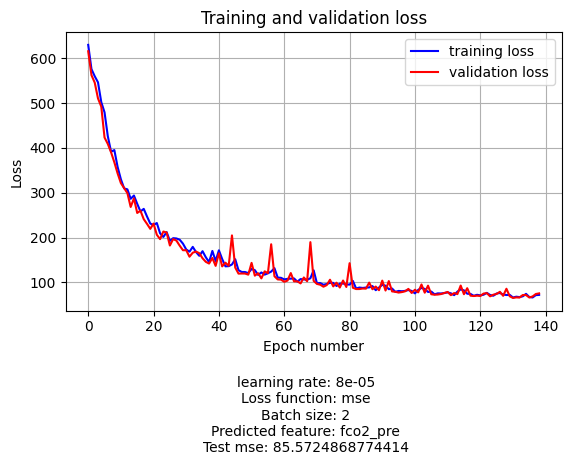

In [9]:
from datetime import datetime


plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.grid(True)
plt.legend()

plt.subplots_adjust(bottom=0.3)
plt.figtext(0.5, 0.01, f"learning rate: {lr}\nLoss function: {loss_function}\nBatch size: {str(batch_size)}\nPredicted feature: fco2_pre\nTest mse: {test_loss}",
            wrap=True, horizontalalignment='center', fontsize=10, color='black')

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
path = '../plots/u-net/' + timestamp + '_training_validation_loss.png'
plt.savefig(path, format='png', dpi=300)
plt.show()  

In [10]:
import joblib
import plot_map

path = "../data/preprocessed_data/"
x = np.load(path + '1959_1_features.npy')
y = np.load(path + '1959_1_targets.npy')
y = y[:,:,1]

x = np.expand_dims(x, axis=0)
pred = model.predict(x)

scaler = joblib.load('scaler.pkl')
flat_x = x[0,:,:,:13].reshape(-1, 13)

denormalized_subset = scaler.inverse_transform(flat_x)
lats_longs = denormalized_subset.reshape(1442, 1021, 13)[:,:,10:12]

result = np.dstack((lats_longs, pred[0], y)).reshape(-1,4)

plot_map.plotAbsolute_numpy(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


In [11]:
def plotPAE_numpy(data, vmax=50):
    # Define map boundaries
    lat_min, lat_max = -77, 90
    lon_min, lon_max = -180, 180

    # Create a grid
    num_lat, num_lon = 360, 720  # Grid resolution
    lat_grid = np.linspace(lat_min, lat_max, num_lat)
    lon_grid = np.linspace(lon_min, lon_max, num_lon)
    lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)

    # Initialize Basemap
    m = Basemap(projection='cyl',
                llcrnrlat=-90, urcrnrlat=90,
                llcrnrlon=-180, urcrnrlon=180,
                resolution='c')

    # Initialize grid with NaNs (to allow masking)
    grid_values = np.full_like(lat_grid, np.nan, dtype=np.float32)

    # Map data points to the nearest grid index
    lat_idx = np.digitize(data[:, 0], lat_grid[:, 0]) - 1
    lon_idx = np.digitize(data[:, 1], lon_grid[0, :]) - 1

    # Assign values to the grid
    grid_values[lat_idx, lon_idx] = abs(data[:, 3]-data[:, 2])/(data[:, 2]+0.001)*100

    plt.figure(figsize=(18, 8))
    m.fillcontinents(color='black')

    # Plot data on the map
    x, y = m(lon_grid, lat_grid)
    pcm = m.pcolormesh(x, y, grid_values, vmin=0, vmax=vmax, cmap='coolwarm', shading='auto')
    m.fillcontinents(color='black')

    # Add colorbar
    cbar = plt.colorbar(pcm, orientation='vertical', pad=0.01)
    cbar.set_label('Pre-industrial CO2 Fugacity')

    plt.title("Absolute error in percent - Pre-industrial CO2 Fugacity")
    timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')
    path = '../plots/u-net/' + timestamp + '_pae_map' + str(vmax) + '.png'
    plt.savefig(path, format='png', dpi=300,  bbox_inches='tight') 
    plt.close()

In [12]:
plotPAE_numpy(result,10)
plotPAE_numpy(result,20)
plotPAE_numpy(result,50)